In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os
import shutil

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml
from tqdm import tqdm

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [30]:
def compute_rdf(nlist, bins=100, r_max=3):
    r = np.linspace(0, r_max, bins + 1)
    H, _ = np.histogram(nlist.distances, bins=r)
    bin_centers = (r[1:] + r[:-1]) / 2
    dr = r[1] - r[0]
    # normalize by volume
    H = H / (2 * np.pi * bin_centers * dr) / len(nlist.distances) * np.pi * r_max ** 2
    return bin_centers, H

@njit
def excess_entropy(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*dr
    prelim[np.isnan(prelim)] = 0
    return -np.pi*np.sum(prelim)

@njit
def excess_entropy_prelim(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*dr
    prelim[np.isnan(prelim)] = 0
    return -np.pi*prelim

@njit
def binary_excess_entropy(r, g_aa, g_ab, g_bb, f_a, f_b, dr):
    prelim_aa = f_a**2*excess_entropy_prelim(r, g_aa, dr)
    prelim_ab = 2*f_b*f_b*excess_entropy_prelim(r, g_ab, dr)
    prelim_bb = f_b**2*excess_entropy_prelim(r, g_bb, dr)
    return np.sum(prelim_aa + prelim_ab + prelim_bb)


@njit
def local_excess_entropy(r, sfs, dr):
    vol = 4*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)
    return out


@njit
def local_excess_entropy_binary(r, sfs, dr):
    vol = 4*np.pi*(r[-1]**2)
    inv_shell = 1/(2*np.pi*r*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr)
    return out

def excess_entropy_ka_2d(r, rdf_aa, rdf_ab, rdf_bb):
    return binary_excess_entropy(r, rdf_aa, rdf_ab, rdf_bb, 0.6, 0.4, r[1] - r[0])

In [63]:

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/excess-entropy-small_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-2:
            continue

        if job.isfile(df_path):
            # dataset = pl.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        traj = gsd.hoomd.open(exper)
        # oexper = exper.replace("traj-fire", "traj")
        # otraj = gsd.hoomd.open(oexper)

        # print(len(traj))
        
        print(max_shear, period, temp)

        entropy = []
        # rdfs = []
        rdf_aas = []
        rdf_abs = []
        rdf_bbs = []
        rs = []
        frames = []
        # types = []
        start = 79
        end = 80
        cycle_start_idx = lambda i: -1 + i*40
        for frame in tqdm(range(cycle_start_idx(start), cycle_start_idx(end))):

            frames.append(frame)

            snap = traj[frame]

            typeids = snap.particles.typeid
            # types.append(typeids)

            box = snap.configuration.box
            pos_a = snap.particles.position[typeids == 0]
            pos_b = snap.particles.position[typeids == 1]

            query_a = freud.locality.AABBQuery.from_system((box, pos_a))
            query_b = freud.locality.AABBQuery.from_system((box, pos_b))

            query_args = {"r_min": 0.01, "r_max": 6.0}
            nlist_aa = query_a.query(pos_a, query_args).toNeighborList()
            nlist_ab = query_b.query(pos_a, query_args).toNeighborList()
            nlist_bb = query_b.query(pos_b, query_args).toNeighborList()
            r, rdf_aa = compute_rdf(nlist_aa, bins=120, r_max=6)
            _, rdf_ab = compute_rdf(nlist_ab, bins=120, r_max=6)
            _, rdf_bb = compute_rdf(nlist_bb, bins=120, r_max=6)

            rdf_aas.append(rdf_aa)
            rdf_abs.append(rdf_ab)
            rdf_bbs.append(rdf_bb)
            rs.append(r)
            
            entropy.append(binary_excess_entropy(r, rdf_aa, rdf_ab, rdf_bb, 0.6, 0.4, r[1] - r[0]))
            # break
        # break
        dataset = pl.DataFrame({"frame": frames, "r": rs, "rdf_aa": rdf_aas, "rdf_ab": rdf_abs, "rdf_bb": rdf_bbs, "entropy": entropy})
        # # dataset = dataset.explode(["id", "soft"]).reset_index(drop=True)
        dataset.write_parquet(job.fn(df_path), use_pyarrow=True)
    #     break
    # break


        
            

634e14bc75836df75158fb15f379d8bb
0.01 1000.0 1.9836e-03


  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


0.02 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.06it/s]


0.02 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


0.03 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


0.03 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


0.05 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


0.05 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


0.08 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


0.08 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


0.12 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.04it/s]


0.12 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.05it/s]


7ec2f6aca035e69077eab24383a21cb6
0.01 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


0.01 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


0.02 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.02it/s]


0.02 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


0.03 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


0.03 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


0.05 1000.0 1.9836e-02


100%|██████████| 40/40 [00:13<00:00,  3.01it/s]


0.05 1000.0 1.9836e-03


100%|██████████| 40/40 [00:13<00:00,  2.96it/s]


0.08 1000.0 1.9836e-02


 85%|████████▌ | 34/40 [00:11<00:01,  3.03it/s]

In [61]:
job.fn(df_path)

'/media/ian/Data2/monk/2d-osc-shear/workspace/634e14bc75836df75158fb15f379d8bb/aqs_therm_experiments/max-shear-0.01/temp-1.9836e-02/excess-entropy-traditional_period-1000.0.parquet'

In [51]:
traj[cycle_start_idx(start)].configuration.box

array([ 1.6524728e+02,  1.6524728e+02,  0.0000000e+00, -6.2797216e-07,
        0.0000000e+00,  0.0000000e+00], dtype=float32)

In [39]:
len(traj)

3200

In [44]:
cycle_start_idx(end)

3239

In [38]:
box

array([ 1.6524728e+02,  1.6524728e+02,  0.0000000e+00, -6.2797216e-07,
        0.0000000e+00,  0.0000000e+00], dtype=float32)

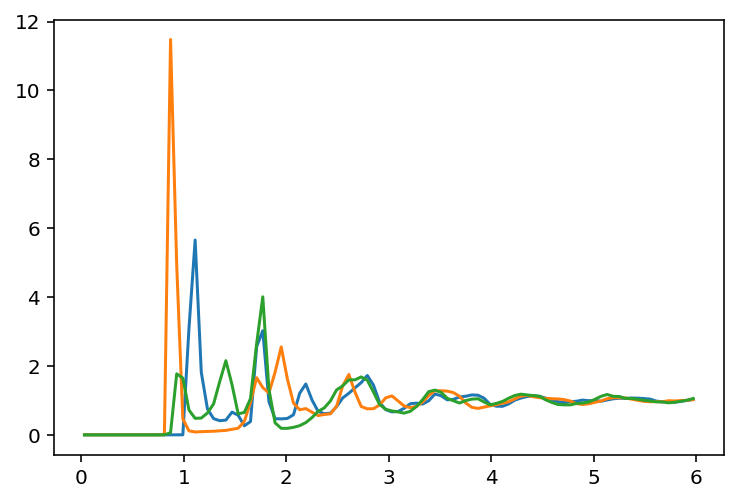

In [57]:
plt.plot(r, rdf_aa)
plt.plot(r, rdf_ab)
plt.plot(r, rdf_bb)

# plt.hlines(1, 0, 10, linestyles=":", color="k")

In [54]:
np.reshape(entropy, (-1, 10)).shape

(40, 10)

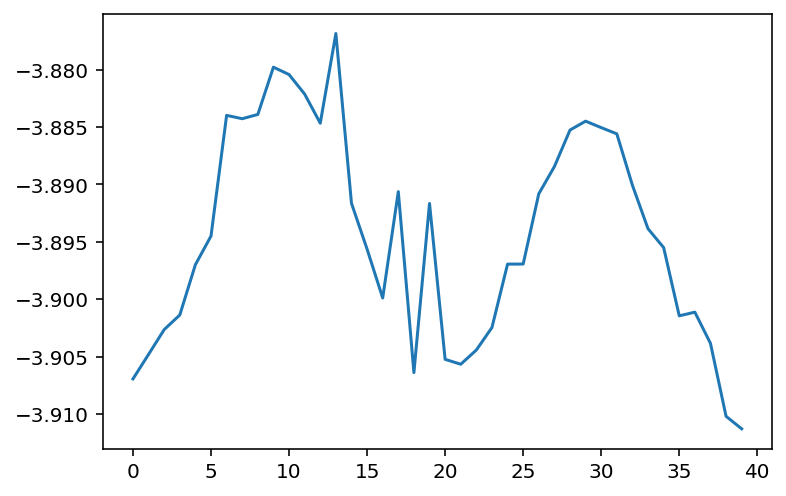

In [56]:
plt.plot(np.reshape(entropy, (-1, 40)).mean(axis=0))

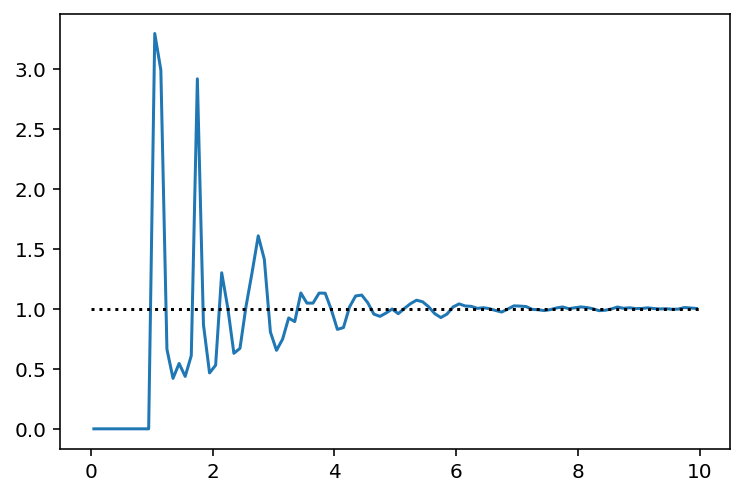

In [22]:
plt.plot(r, rdfs[-1])
plt.hlines(1, 0, 10, linestyles=":", color="k")
# plt.plot(rdfs[-2])

In [89]:
np.reshape(entropy[:-1], (3, -1)).shape

(3, 40)

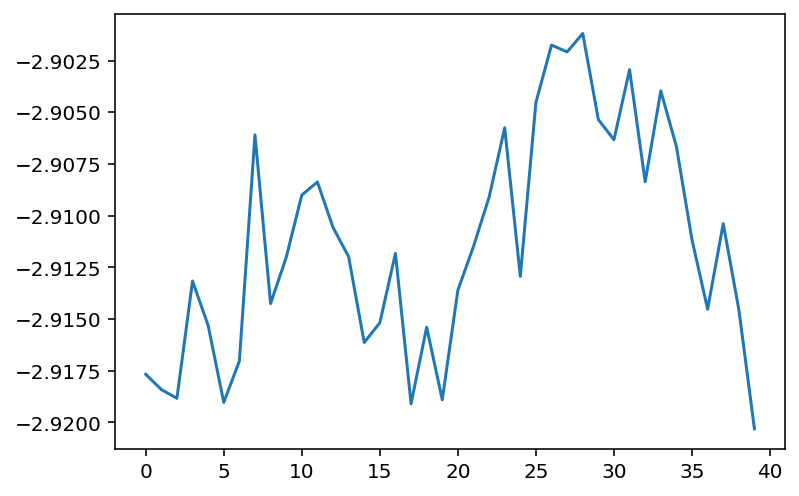

In [90]:
plt.plot(np.mean(np.reshape(entropy[:-1], (3, -1)), axis=0))

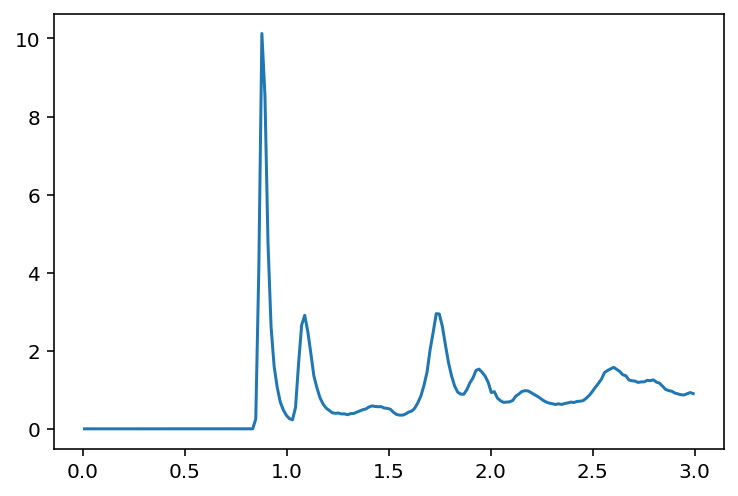

In [30]:
r, rdf = compute_naive_rdf(nlist, bins=200)
plt.plot(r, rdf)

In [66]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
            output[sp].append(dataset)
            continue


634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


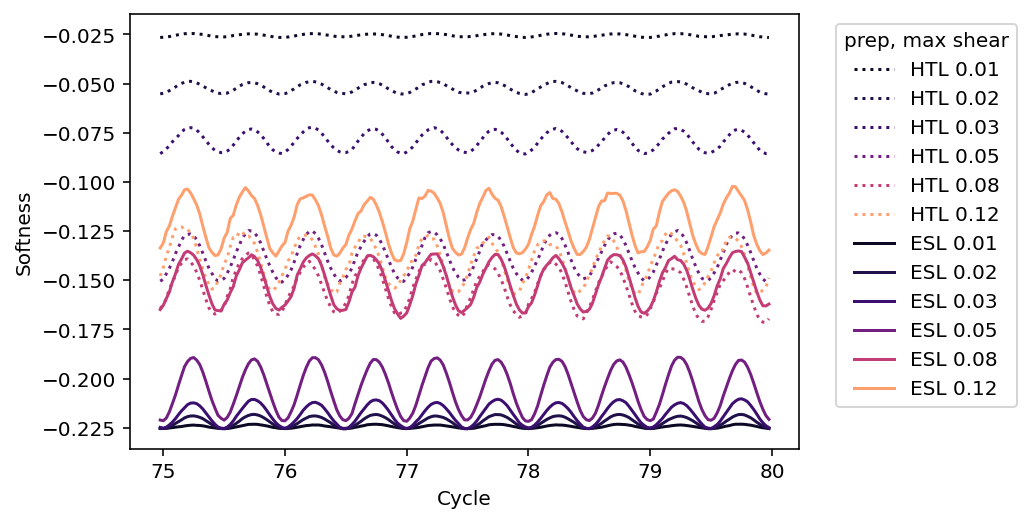

In [67]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

for key, value in output.items():
    if key.prep == "HTL":
        ln = ":"
    else:
        ln = "-"
    # print(key, len(value))
    dataset = pl.concat(value)
    xs = []
    ys = []
    
    for frame, df in dataset.group_by("frame", maintain_order=True):
        # print(frame)
        df = df.explode(["id", "soft"])
        mean_soft = df["soft"].mean()

        xs.append(frame/40)
        ys.append(mean_soft)
    plt.plot(xs, ys, linestyle=ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")
    # break
plt.xlabel("Cycle")
plt.ylabel("Softness")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")

In [70]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
            output[sp].append(dataset)
            continue

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


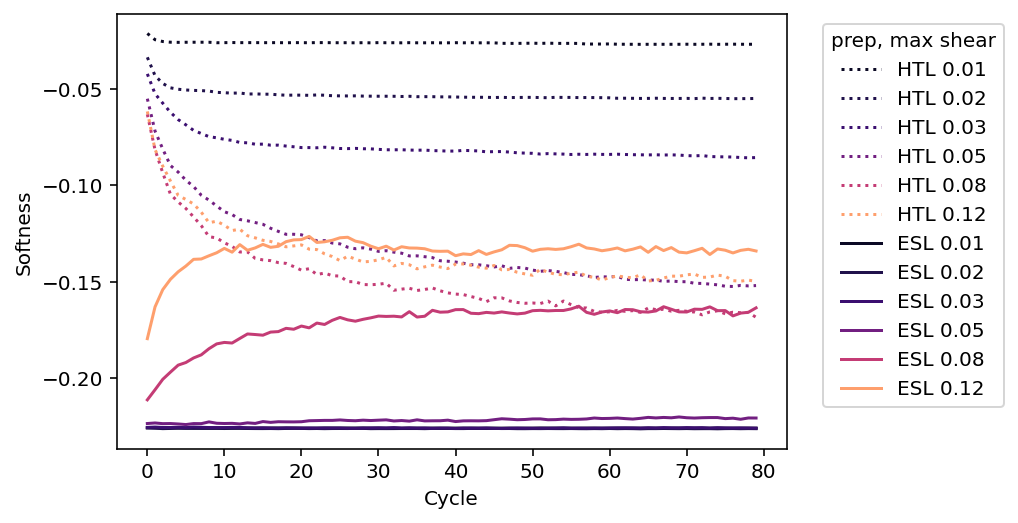

In [71]:
cmap = cm.magma
norm = colors.Normalize(vmin=0, vmax=0.15)

for key, value in output.items():
    if key.prep == "HTL":
        ln = ":"
    else:
        ln = "-"
    xs = []
    ys = []
    yerrs = []

    dataset = pl.concat(value)

    for frame, df in dataset.group_by("frame", maintain_order=True):
        df = df.explode(["id", "soft"])
        xs.append(frame)
        ys.append(df["soft"].mean())
        yerrs.append(df["soft"].std())

    xs = np.array(xs)
    ys = np.array(ys)
    yerrs = np.array(yerrs)

    plt.plot(ys, linestyle=ln, color=cmap(norm(key.max_shear)), label=f"{key.prep} {key.max_shear:.2f}")

plt.xlabel("Cycle")
plt.ylabel("Softness")
# put legend outside to the right
plt.legend(title="prep, max shear", bbox_to_anchor=(1.04,1), loc="upper left")

In [ ]:
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    # print(prep)
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))
    if len(experiments) == 0:
        continue
    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/final-cycles-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        if job.isfile(df_path):
            dataset = pl.read_parquet(job.fn(df_path), use_pyarrow=True)
            output[sp].append(dataset)
            continue